# Menggunakan EfficientNet

In [1]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import warnings
pd.set_option('display.max_colwidth', None)
pd.options.display.max_rows = 5
warnings.simplefilter("ignore")
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## preprocessing

In [3]:
data_dir = '/content/drive/MyDrive/tampak depan'

def load_data_from_directory(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                if os.path.isfile(image_path):
                    image_paths.append(image_path)
                    labels.append(label)

    df = pd.DataFrame({
        'Image Path': image_paths,
        'Label': labels
    })

    return df

def train_val_test_split(X, y, train_size, val_size, test_size):
    """
    Splits the data into train, validation, and test sets.
    """
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size)
    val_test_split = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=val_test_split)

    train_df = pd.DataFrame({'Image Path': X_train, 'Label': y_train})
    val_df = pd.DataFrame({'Image Path': X_val, 'Label': y_val})
    test_df = pd.DataFrame({'Image Path': X_test, 'Label': y_test})

    return train_df, val_df, test_df


df = load_data_from_directory(data_dir)

train_df, val_df, test_df = train_val_test_split(df['Image Path'], df['Label'], train_size=0.8, val_size=0.1, test_size=0.1)

print(f"Train df ({train_df.shape}), val df ({val_df.shape}), test df ({test_df.shape})")


Train df ((3902, 2)), val df ((488, 2)), test df ((488, 2))


In [4]:
train_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)

train_gen = train_datagen.flow_from_dataframe(train_df, batch_size=10,shuffle=True,directory='Train', x_col='Image Path',y_col='Label', target_size=(150,150),class_mode='categorical')

valid_datagen = ImageDataGenerator()

valid_gen = valid_datagen.flow_from_dataframe(val_df, batch_size=10,shuffle=True,directory='Train', x_col='Image Path', y_col='Label',target_size=(150,150), class_mode='categorical')

length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
test_gen=valid_datagen.flow_from_dataframe(test_df, directory='Train', x_col='Image Path', y_col='Label', target_size=(150,150),
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 3902 validated image filenames belonging to 5 classes.
Found 488 validated image filenames belonging to 5 classes.
Found 488 validated image filenames belonging to 5 classes.


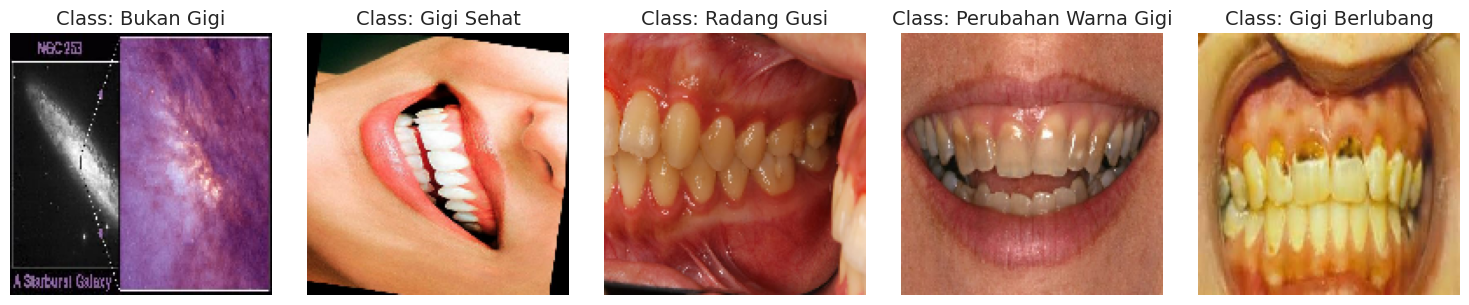

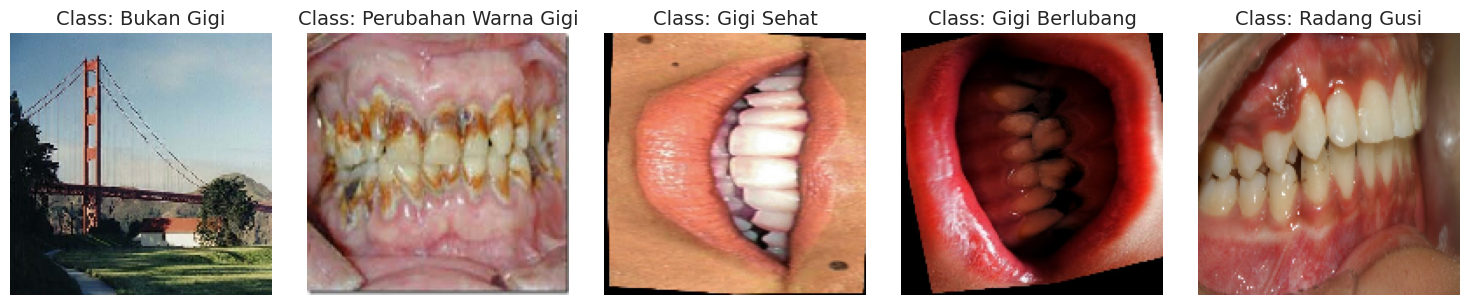

In [15]:
def show_random_samples(dataframe, directory, x_col, y_col, target_size=(150, 150), n_samples=1):
    unique_classes = dataframe[y_col].unique()
    fig, axes = plt.subplots(n_samples, len(unique_classes), figsize=(len(unique_classes) * 3, n_samples * 3))

    for i, label in enumerate(unique_classes):
        samples = dataframe[dataframe[y_col] == label].sample(n_samples)
        for j, idx in enumerate(samples.index):
            img_path = os.path.join(directory, samples.loc[idx, x_col])
            img = load_img(img_path, target_size=target_size)
            ax = axes[j, i] if n_samples > 1 else axes[i]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(f"Class: {label}", fontsize=14)

    plt.tight_layout()
    plt.show()

# Show random samples from the training set
show_random_samples(train_df, 'Train', 'Image Path', 'Label', n_samples=1)

# Show random samples from the validation set
show_random_samples(val_df, 'Train', 'Image Path', 'Label', n_samples=1)


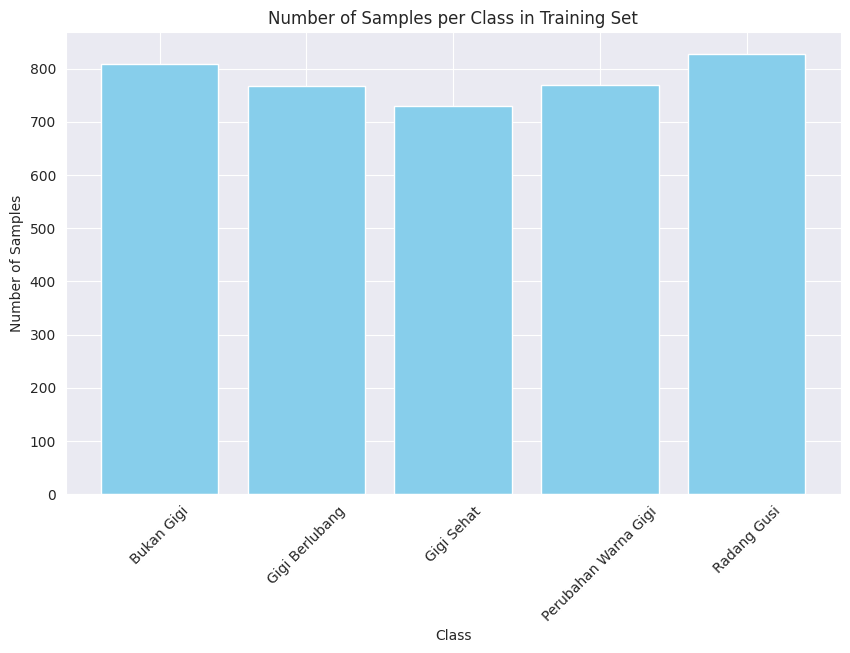

In [30]:
class_counts = Counter(train_gen.classes)
class_labels = list(train_gen.class_indices.keys())
sorted_class_counts = [class_counts[i] for i in range(len(class_labels))]

plt.figure(figsize=(10, 6))
plt.bar(class_labels, sorted_class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples per Class in Training Set')
plt.xticks(rotation=45)
plt.show()

In [5]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs['accuracy'] > 0.97 and logs['val_accuracy'] > 0.97:
                print("\nReached 97% training accuracy and 97% validation accuracy, so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

## Model

In [6]:
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

In [7]:
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=(150,150,3), pooling='max')
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(5, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 [==============================] - 0s 0us/step


In [8]:
history=model.fit(x=train_gen,  epochs=50, verbose=1,  validation_data=valid_gen, callbacks=[callbacks])

Epoch 1/50
391/391 [==============================] - 4114s 10s/step - loss: 18.9950 - accuracy: 0.6187 - val_loss: 12.4163 - val_accuracy: 0.8053
Epoch 2/50
391/391 [==============================] - 71s 180ms/step - loss: 8.5705 - accuracy: 0.7665 - val_loss: 5.5859 - val_accuracy: 0.8525
Epoch 3/50
391/391 [==============================] - 71s 182ms/step - loss: 4.1421 - accuracy: 0.8188 - val_loss: 2.7332 - val_accuracy: 0.8893
Epoch 4/50
391/391 [==============================] - 71s 182ms/step - loss: 2.1399 - accuracy: 0.8483 - val_loss: 1.4464 - val_accuracy: 0.9016
Epoch 5/50
391/391 [==============================] - 71s 181ms/step - loss: 1.2796 - accuracy: 0.8526 - val_loss: 0.9000 - val_accuracy: 0.9160
Epoch 6/50
391/391 [==============================] - 72s 185ms/step - loss: 0.8890 - accuracy: 0.8857 - val_loss: 0.6664 - val_accuracy: 0.9365
Epoch 7/50
391/391 [==============================] - 71s 182ms/step - loss: 0.7598 - accuracy: 0.8849 - val_loss: 0.6329 - val_

In [9]:
model_save_path = os.path.join(data_dir, 'efficient_bagus.h5')
model.save(model_save_path)

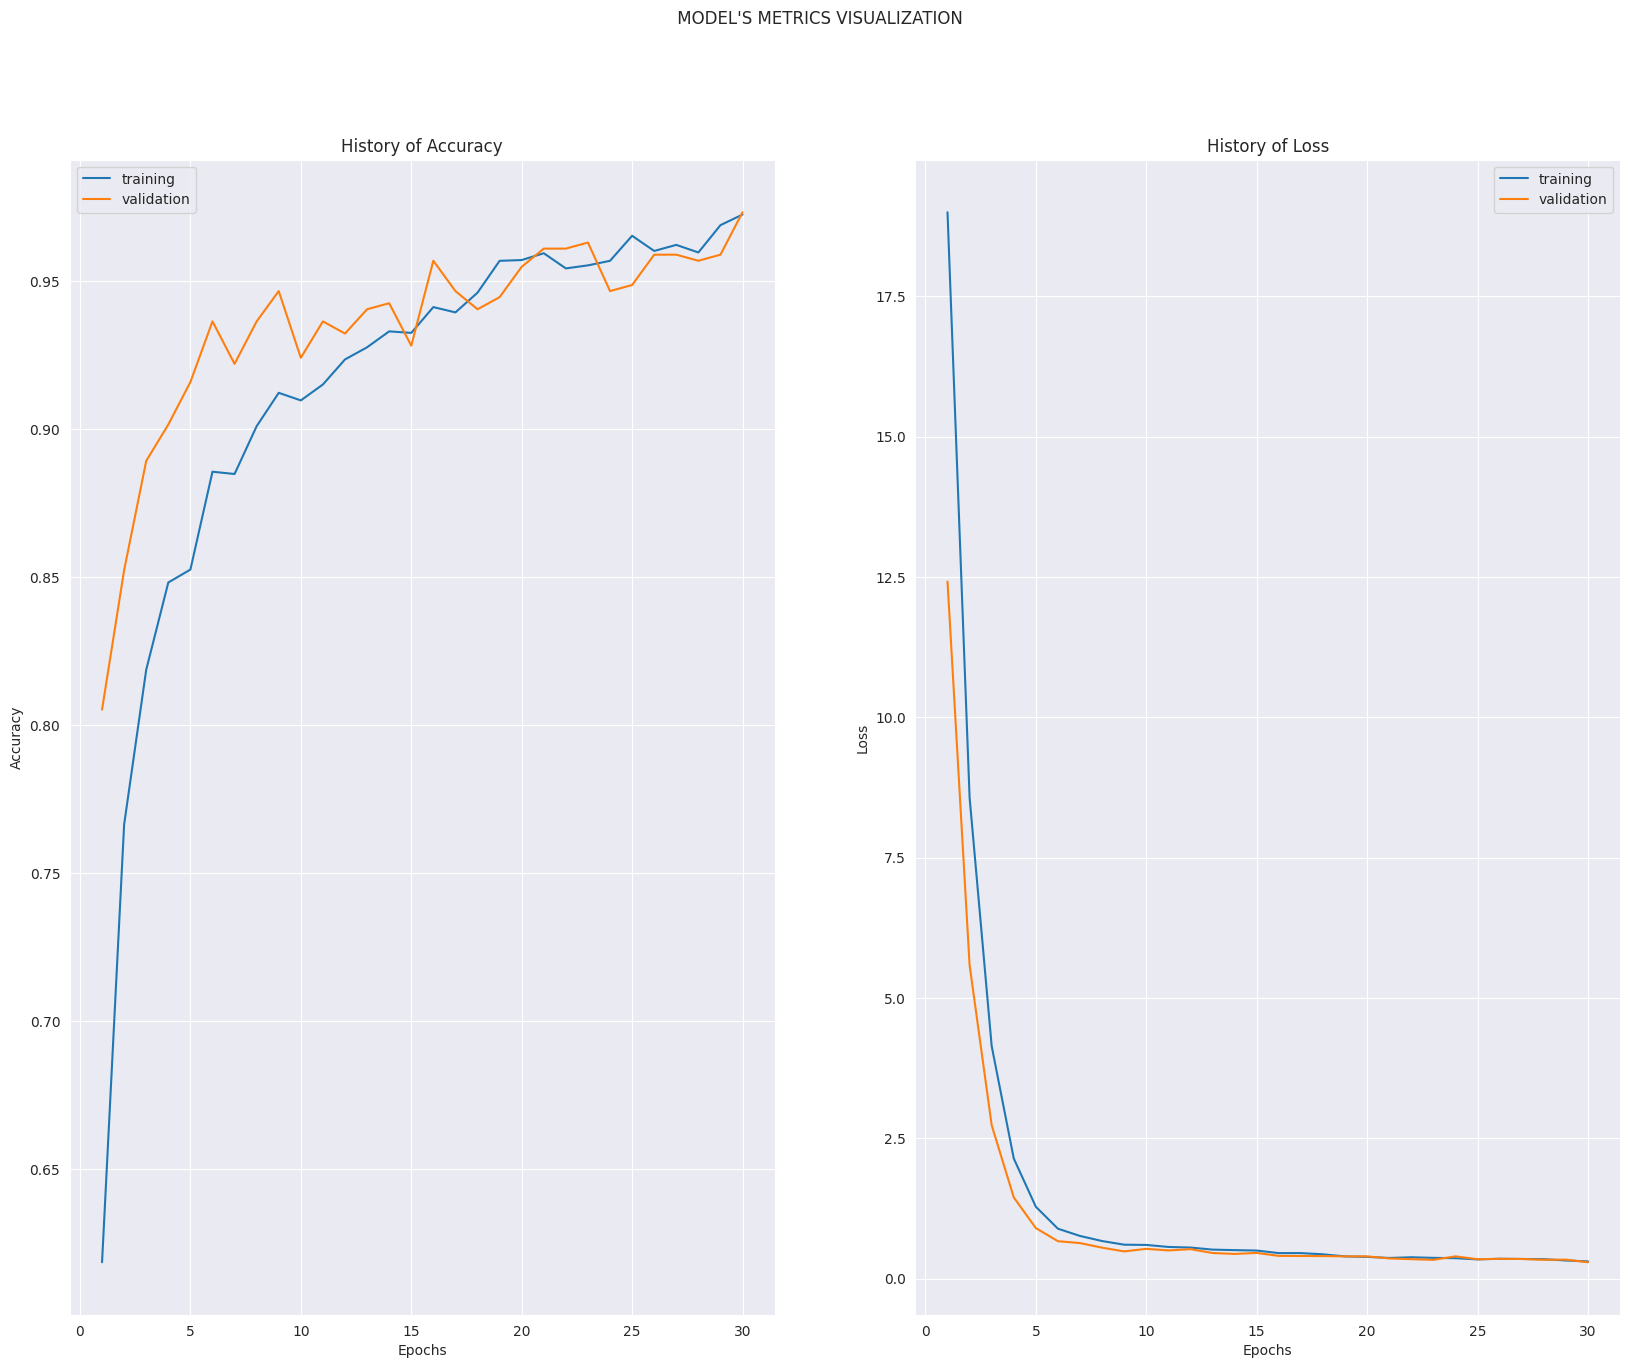

In [10]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (20,15))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()


Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])